##  Quantile Regression - Pinball Loss function

In the [previous notebook](http://localhost:8888/notebooks/bayesian_deep_learning/uncertainty_estimation/quantile_regression/experiments/01-quantile_regression/01-quantile_regression_techniques.ipynb), it has been validated the Pinball/Quantile Loss as a good uncertainty metric for evaluating prediction intervals.

The goal of this notebook is to have an intuitive idea of the theory and limitations behind the **quantile loss function**.

In [4]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import norm
from sklearn import ensemble

import tensorflow as tf
from tensorflow import keras
tf.get_logger().setLevel('INFO')

mpl.rcParams['figure.figsize'] = 20, 10

## Introduction

* [Reference post](https://medium.com/analytics-vidhya/prediction-intervals-in-forecasting-quantile-loss-function-18f72501586f) explaning the loss function in forecasting problems

The notebook is organized in the following two sections:

- **Quantile loss formulation**. It is explained the theory and implementation details of the quantile loss formula for evaluating prediction intervals.

- **Bayesian interpretation of the quantile loss function**. It is analyzed the assumptions (or beliefs) imposed over the model residual distribution.

### Quantile loss formulation

The quantile loss uses the following formulation:

*Loss individual data point*

$$
\begin{align}
\mathcal{L}(\xi_i|\alpha)=\begin{cases}
\alpha \xi_i &\text{if }\xi_i\ge 0, \\
(\alpha-1) \xi_i &\text{if }\xi_i< 0.
\end{cases}
\end{align}
$$

* $\alpha$: the required quantile (a value between 0 and 1)
* $\xi_i = y_i - f(\mathbf{x}_i)$
* $f(\mathbf{x}_i)$ is the predicted (quantile)

*Loss global function*

$$\mathcal{L}(\mathbf{y},\mathbf{f}|\alpha)=\frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i-f(\mathbf{x}_i)|\alpha)$$

In [5]:
def quantile_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = f - y
    #e = y - f . NOTE: IMPORTANT!! Sometimes the error is computed in this form 
    return np.maximum(q * e, (q - 1) * e)

#### Intuitive interpretation

The quantile loss formula have two terms:
 -  q * e
 - (q - 1) * e

In the practice, only one of the two terms will be applied (the maximum value form both). The term will be applied depending on the sign of prediction residual:

* *Over-predicting* f > y. The error will be positive and the first term will dominate 
* *Under-predicting* f < y. The error will be negative and the second term will dominate

Additionally, it is applied different weights to residuals obtained from over-predictions (positive) and under-predictions (negative) depending on the quantile value. Thus, Q is a penalization factor:

 * q=0.5 under-prediction and over-prediction will be penalized by the same factor, the median is obtained
 * q=0.75 over-predictions (positive residual) will be penalized by a factor of 0.75, and under-predictions (negative residual) by a factor of 0.25

**Example**

In the following figure it is represented an example. Here, we can see that the model output (prediction) is under the observed true value. Thus, this is a case of **under-predicting**.

In this case, if we would like to estimate a quantile of q=0.25, this specific (negative) residual will be penalized more heavily than positive residual. The second term of the loss will become positive and dominate (-0.75*-e > 0.25*-e) 

<img src="../../img/prediction_interval.png" width="300">

This formula leads us to an **assymmetric form** of the loss function visualized before.

#### Loss function visualization

First, it is artificially generated error values in a interval of [-1,1] in order to understand how the quantile loss function behaves. 

In [6]:
quantile_loss_error = np.linspace(-1, 1, 1000)
quantile_loss_error_loss_10 = quantile_loss(0.1, 0, quantile_loss_error)
quantile_loss_error_loss_50 = quantile_loss(0.5, 0, quantile_loss_error)
quantile_loss_error_loss_90 = quantile_loss(0.9, 0, quantile_loss_error)

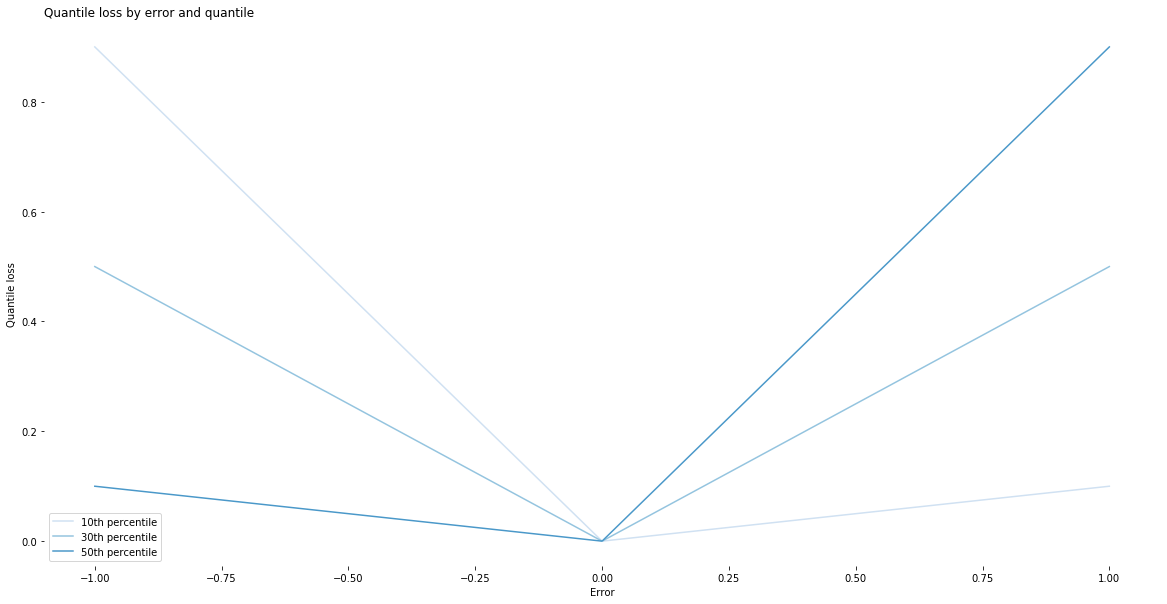

In [7]:
with sns.color_palette('Blues', 4):
    plt.plot(quantile_loss_error, quantile_loss_error_loss_10)
    plt.plot(quantile_loss_error, quantile_loss_error_loss_50)
    plt.plot(quantile_loss_error, quantile_loss_error_loss_90)
    plt.legend([str(int(q * 100)) + 'th percentile' for q in [0.1, 0.3, 0.5, 0.7, 0.9]])
    sns.despine(left=True, bottom=True)
    plt.xlabel('Error')
    plt.ylabel('Quantile loss')
    plt.title('Quantile loss by error and quantile', loc='left');

As we can see, the quantile loss value is dependent on the evaluated quantile. For the case of the quantile 50th the obtained loss is symmetric in both sides of [-1,0] and [0,1] so the errors comming from the predictions of both sides of the true value (overpredictting and underpredictting) are penalized equally. 

More positive errors are penalized more for higher quantiles and more negative errors are penalized more for lower quantiles. 

### Bayesian interpretation of the quantile loss function

* [Reference post](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html) explaning the relationship of the quantile loss function and ALD distirbution

In the 'On-the-fly' technique is implemented the mean squared error function for optimizing model paremeters. As we have seen with this technique, this formulation **assumes a gaussian error distribution**. The mode of this distribution (the peak) corresponds to the mean parameter and the variance of the distribution with rmse.

In the case of the quantile loss, if we take the negative of the individual loss and exponentiate it, we get the distribution know as the [*Asymmetric Laplace distribution*](https://en.wikipedia.org/wiki/Asymmetric_Laplace_distribution)

**Thus, here we are assuming that individual quantiles estimation follows an ALD distribution**

### Conclusions

Goals achieved in this notebook:
  * Gain an intuitive idea of the theory and limitations behind the quantile loss function. 
  * Bayesian interpretation of the quantile loss function